In [1]:
import numpy as np
import pbdlib as pbd
import matplotlib.pyplot as plt

import tf_oc as oc
from IPython.core import display
import tensorflow as tf

%matplotlib inline
%load_ext autoreload
%autoreload 2

demos.py -f policy_001 -p $HOME/code/pbdlib/public/pbdlib/pop/data/tests/

3 without and with prior

5, 6, 7 without

In [2]:
demo_name = 'policy_001'

In [3]:
data = np.load('./data/tests/%s.npy' % demo_name)[()]

In [4]:
x_in = np.concatenate(data['x'], axis=0)
x_out = np.concatenate(data['dx'], axis=0)
x_joint = np.concatenate([x_in, x_out], axis=1)
print x_in.shape, x_out.shape

(324, 2) (324, 2)


In [5]:
# plt.plot(np.diff(data['x'][0][:, 0])/0.05)
# plt.plot(data['dx'][0][:, 0])

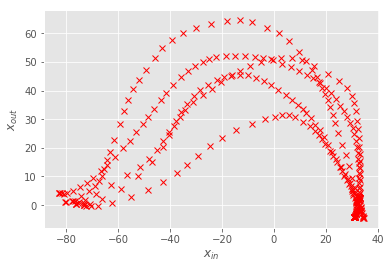

In [6]:
plt.plot(x_in[:, 0], x_in[:, 1], 'rx')
plt.xlabel(r'$x_{in}$')
plt.ylabel(r'$x_{out}$')

In [7]:
n_in = x_in.shape[1]
n_out = x_out.shape[1]
n_joint = x_joint.shape[1]
n_data = x_joint.shape[0]

### Covariance prior 

In [8]:
cov_tril = 14. * np.eye(4)
# cov_tril[2:4, :2] = -8. * np.eye(2)
cov_tril[2:4, :2] = 0. * np.eye(2)
cov = cov_tril.T.dot(cov_tril)
print cov

[[196.   0.   0.   0.]
 [  0. 196.   0.   0.]
 [  0.   0. 196.   0.]
 [  0.   0.   0. 196.]]


In [9]:
joint_model = pbd.VBayesianGMM({
        'n_components':23, 'n_init':1, 'reg_covar': 0.6 ** 2,
        'covariance_prior': cov, 'mean_precision_prior':20. ** -2,
        'weight_concentration_prior_type':'dirichlet_process', 'weight_concentration_prior': 1e3,
        'degrees_of_freedom_prior': n_joint - 1. + 0.3 })


In [10]:
joint_model.posterior(data=x_joint, dp=False)

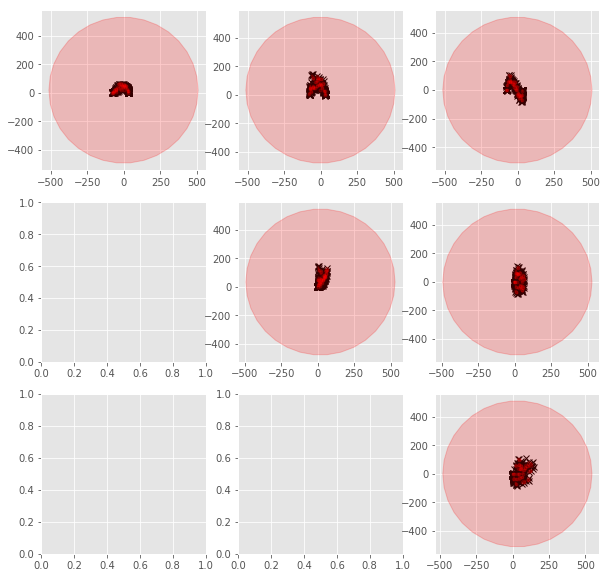

In [11]:
fig, ax = plt.subplots(nrows=n_joint-1, ncols=n_joint-1, figsize=(10, 10))

for i in range(n_joint):
    for j in range(n_joint):
        if not i == j and j>i:
            ax[i][j-1].plot(x_joint[:, i], x_joint[:, j], 'kx')
            joint_model.plot(dim=[i, j], ax=ax[i][j-1], alpha=0.2)

In [13]:
joint_model.posterior(data=x_joint)

In [14]:
def f(x, use_gmr=False):
    if use_gmr:
        return gmr_model.condition(x, slice(0, n_in), slice(n_in, n_joint))[0]
    else:
        return joint_model.condition(x, slice(0, n_in), slice(n_in, n_joint))[0]

In [15]:
def uncertainty(x):
    return -np.log(joint_model.get_pred_post_uncertainty(x, slice(0, n_in), slice(n_in, n_joint)))

### Bayesian DP-GMM policy 

In [16]:
joint_model.nb_states

23

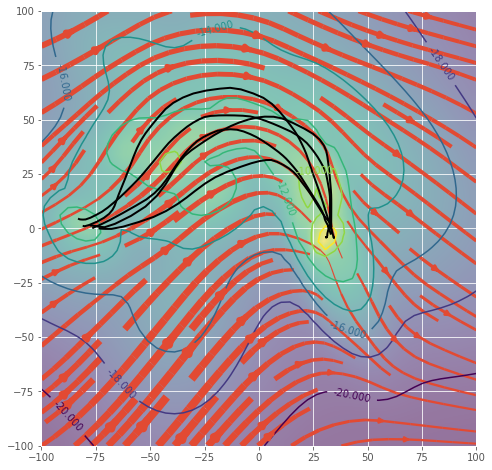

In [17]:
plt.figure(figsize=(8, 8))
pbd.plot_dynamic_system(f, xlim=[-100, 100], ylim=[-100, 100], equal=True, scale=0.05)
pbd.plot_function_map(uncertainty, xlim=[-100, 100], ylim=[-100, 100], nb_sub=80, opp=False)
# joint_model.plot(dim=[0, 1], alpha=0.2)
for d in data['x']:
    plt.plot(d[:, 0], d[:, 1], 'k', lw=2)

### Create stable controller 

In [18]:
dt = 0.05

In [19]:
A = np.eye(2)
B = dt * np.eye(2) 
T = max([d.shape[0] for d in data['x']]) + 50

In [20]:
lqr = pbd.LQR(A, B, horizon=T)

In [53]:
cost_xi = pbd.GMM(nb_states=2, nb_dim=2)

diag = lambda x: np.eye(x.shape[-1]) * x

cost_xi.mu = np.array([
    # data distribution
    np.mean(x_joint[:, :2], axis=0), 
    # end state distribution
    np.mean([d[-1] for d in data['x']], axis=0)
])

cost_xi.sigma = [
    8 * diag(np.cov(x_joint[:, :2], rowvar=False)), # data distribution
    4 * diag(np.cov([d[-1] for d in data['x']],rowvar=False)) # end state distribution 
]

cost_u = pbd.MVN(nb_dim=2)

cost_u.mu = np.zeros(2)
cost_u.sigma = 8. * diag(np.cov(x_joint[:, :2], rowvar=False))

In [54]:
lqr.gmm_xi = cost_xi, [0 for i in range(T - 50)] + [1 for i in range(50)]
lqr.gmm_u = cost_u

In [55]:
lqr.ricatti()

In [56]:
lqr.Q[0]

array([[11659.46,     0.  ],
       [    0.  ,  2942.75]])

In [57]:
def stable_policy(x, t=0):
    return np.einsum('ij,ai->aj', lqr.K[t], lqr.ds[t]-x), lqr.Q[t] * np.ones_like(x)[:, :, None]

In [58]:
slogdet = [np.linalg.slogdet(stable_policy(np.zeros((1, 2)), t)[1][0])[1] for t in range(0, 130)]

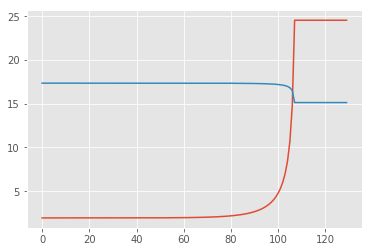

In [60]:
plt.plot([np.sum(lqr.K[t]) for t in range(0, 130)])
plt.plot(slogdet)

In [26]:
# n = 5
# fig, ax = plt.subplots(ncols=n, figsize=(4* n, 4))

# for i, t in enumerate(np.linspace(0, T-2, n)):
#     pbd.plot_dynamic_system(
#         lambda x: stable_policy(x, t=int(t))[0],
#         xlim=[-100, 100], ylim=[-100, 100], equal=True, scale=0.02, ax=ax[i])

# for d in data['x']:
#     plt.plot(d[:, 0], d[:, 1], 'k', lw=2)

## Product of policies 

In [27]:
def product_policy(x, t=0):
    mu_1, sigma_1 = joint_model.condition(x, slice(0, n_in), slice(n_in, n_joint))
    mu_2, sigma_2 = stable_policy(x, t)
    
    lmbda_1, lmbda_2 = np.linalg.inv(sigma_1), np.linalg.inv(sigma_2) 
    lmbda_p = lmbda_1 + lmbda_2
    
    mu_p = np.einsum('aij,aj->ai',np.linalg.inv(lmbda_p),(np.einsum('aij,aj->ai', lmbda_1, mu_1) +
     np.einsum('aij,aj->ai', lmbda_2, mu_2)))
    return mu_p

In [28]:
xis = [np.copy(data['x'][2][0])]


for i in range(0, T-6):
    u = product_policy(xis[-1][None], i)[0]
    xis += [A.dot(xis[-1]) + B.dot(u)]
    
xis = np.array(xis)

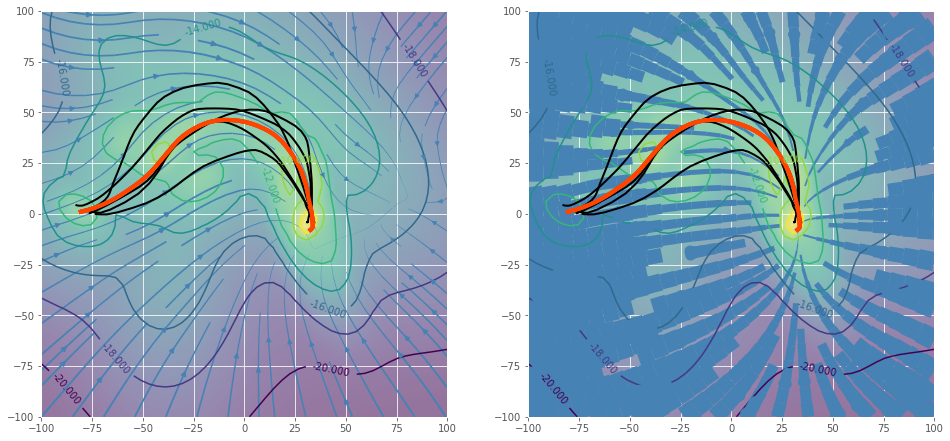

In [29]:
fig, ax= plt.subplots(ncols=2, figsize=(16, 8))

pbd.plot_dynamic_system(
    lambda x: product_policy(x, t=0),
    xlim=[-100, 100], ylim=[-100, 100], equal=True, scale=0.02, ax=ax[0],
    color='steelblue'
)

pbd.plot_dynamic_system(
    lambda x: product_policy(x, t=-50),
    xlim=[-100, 100], ylim=[-100, 100], equal=True, scale=0.02, ax=ax[1],
    color='steelblue'
)


for i in range(2):
    pbd.plot_function_map(
        uncertainty, xlim=[-100, 100], ylim=[-100, 100], nb_sub=40, opp=False, ax=ax[i])

    for d in data['x']:
        ax[i].plot(d[:, 0], d[:, 1], 'k', lw=2)

        ax[i].plot(xis[:, 0], xis[:, 1], lw=4, color='orangered')

In [343]:
import imageio
import os

In [347]:
images = []
name = demo_name + '_dp_gmm_lqr'
# for t in range(0, 6, 6):
for t in range(0, T-6, 3):
    plt.figure(figsize=(8, 8))
    
    pbd.plot_dynamic_system(
        lambda x: product_policy(x, t=t),
        xlim=[-100, 100], ylim=[-100, 100], equal=True, scale=0.03,
        color='steelblue'
    )
    
    pbd.plot_function_map(
        uncertainty, xlim=[-100, 100], ylim=[-100, 100], nb_sub=40, opp=False)
    
    for d in data['x']:
        plt.plot(d[:, 0], d[:, 1], 'k--', lw=2, alpha=0.6)
        
    plt.plot(xis[:t, 0], xis[:t, 1], color='orangered', lw=3)
    plt.plot(xis[t, 0], xis[t, 1], 'ws', mec='orangered', ms=10, mew=2)
    
    plt.savefig('img_%d.png' % t)
    
    images.append(imageio.imread('img_%d.png' % t))
    os.remove('img_%d.png' % t)
    plt.close()
    
imageio.mimsave('%s.mp4' % name, images)